In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-2.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,18,50,41,1.49,59,82,2020-01-11 17:07:49
1,18,50,41,1.50,59,82,2020-01-11 17:07:43
2,18,50,41,1.50,59,82,2020-01-11 17:07:39
3,18,50,41,1.50,60,83,2020-01-11 17:07:28
4,18,50,41,1.50,60,83,2020-01-11 17:07:24


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089280 entries, 0 to 1089279
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   temp    1089280 non-null  int64         
 1   hum     1089280 non-null  int64         
 2   co      1089280 non-null  int64         
 3   no2     1089280 non-null  float64       
 4   pm2_5   1089280 non-null  int64         
 5   pm10    1089280 non-null  int64         
 6   date    1089280 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 58.2 MB


In [5]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [6]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 05:00:00,23.00,89.00,15.76,19.25,28.34,39.31
2019-09-13 06:00:00,23.14,87.31,16.27,19.25,32.36,44.94
2019-09-13 07:00:00,24.23,83.01,16.25,19.26,58.58,82.12
2019-09-13 08:00:00,25.45,76.43,16.15,19.26,43.30,60.28
2019-09-13 09:00:00,27.85,66.55,16.39,19.25,48.00,66.76
...,...,...,...,...,...,...
2020-01-11 13:00:00,18.88,48.85,41.00,1.38,89.39,124.32
2020-01-11 14:00:00,19.03,47.54,41.00,1.43,77.89,108.28
2020-01-11 15:00:00,19.00,46.44,41.00,1.47,64.70,89.90


In [7]:
pm = one_hr_sample[['PM2.5']].copy()

In [8]:
pm

,PM2.5
date,
2019-09-13 05:00:00,28.34
2019-09-13 06:00:00,32.36
2019-09-13 07:00:00,58.58
2019-09-13 08:00:00,43.30
2019-09-13 09:00:00,48.00
...,...
2020-01-11 13:00:00,89.39
2020-01-11 14:00:00,77.89
2020-01-11 15:00:00,64.70


In [9]:
df = pm.copy()

In [10]:
#df = df[:2886]
df

,PM2.5
date,
2019-09-13 05:00:00,28.34
2019-09-13 06:00:00,32.36
2019-09-13 07:00:00,58.58
2019-09-13 08:00:00,43.30
2019-09-13 09:00:00,48.00
...,...
2020-01-11 13:00:00,89.39
2020-01-11 14:00:00,77.89
2020-01-11 15:00:00,64.70


In [11]:
df.isna().sum()

PM2.5    1142
dtype: int64

In [12]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

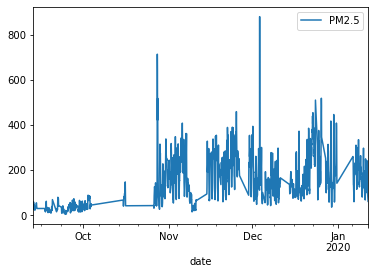

In [13]:
df.plot()

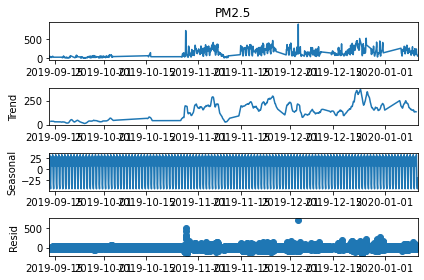

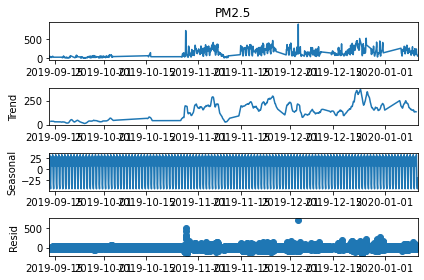

In [14]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [15]:
len(df)

2893

In [16]:
train = df.iloc[:2869]
test = df.iloc[2869:]

scaler = MinMaxScaler()

In [17]:
df.head(), df.tail()

(                     PM2.5
 date                      
 2019-09-13 05:00:00  28.34
 2019-09-13 06:00:00  32.36
 2019-09-13 07:00:00  58.58
 2019-09-13 08:00:00  43.30
 2019-09-13 09:00:00  48.00,
                      PM2.5
 date                      
 2020-01-11 13:00:00  89.39
 2020-01-11 14:00:00  77.89
 2020-01-11 15:00:00  64.70
 2020-01-11 16:00:00  64.13
 2020-01-11 17:00:00  60.89)

In [18]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.02829435],
       [0.03288078],
       [0.06279521],
       [0.04536224],
       [0.05072447],
       [0.04333143],
       [0.03057616],
       [0.03297205],
       [0.03249287],
       [0.02310325]])

# Recursive Strategy

In [19]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.02829435],
         [0.03288078],
         [0.06279521],
         [0.04536224],
         [0.05072447],
         [0.04333143],
         [0.03057616],
         [0.03297205],
         [0.03249287],
         [0.02310325],
         [0.02780376],
         [0.03410154],
         [0.04109527],
         [0.03640616],
         [0.02851112],
         [0.02158585],
         [0.02287507],
         [0.02459783],
         [0.02989161],
         [0.03270964],
         [0.03437536],
         [0.03888192],
         [0.04152881],
         [0.04274957]]]),
 array([[0.04358243]]))

In [20]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
2845/2845 [==============================] - 88s 15ms/step - loss: 0.0039
Epoch 2/10
2845/2845 [==============================] - 42s 15ms/step - loss: 0.0019
Epoch 3/10
2845/2845 [==============================] - 29s 10ms/step - loss: 0.0015
Epoch 4/10
2845/2845 [==============================] - 29s 10ms/step - loss: 0.0014
Epoch 5/10
2845/2845 [==============================] - 29s 10ms/step - loss: 0.0015
Epoch 6/10
2845/2845 [==============================] - 30s 10ms/step - loss: 0.0017
Epoch 7/10
2845/2845 [==============================] - 30s 11ms/step - loss: 0.0014
Epoch 8/10
2845/2845 [==============================] - 30s 11ms/step - loss: 0.0014
Epoch 9/10
2845/2845 [==============================] - 30s 10ms/step - loss: 0.0018
Epoch 10/10
2845/2845 [==============================] - 30s 10ms/step - loss: 0.0016


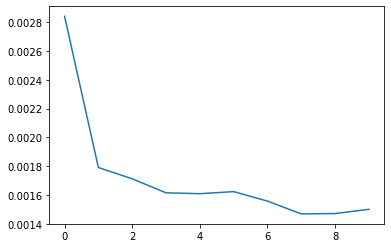

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [23]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.15397304]], dtype=float32)

In [24]:
scaled_test[0], scaled_test[1]

(array([0.22958357]), array([0.2803765]))

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.15397304], dtype=float32),
 array([0.1777727], dtype=float32),
 array([0.19226106], dtype=float32),
 array([0.19935656], dtype=float32),
 array([0.20029578], dtype=float32),
 array([0.19691144], dtype=float32),
 array([0.19091193], dtype=float32),
 array([0.18385231], dtype=float32),
 array([0.1772392], dtype=float32),
 array([0.17221273], dtype=float32),
 array([0.16951078], dtype=float32),
 array([0.16917217], dtype=float32),
 array([0.17095904], dtype=float32),
 array([0.17432487], dtype=float32),
 array([0.17860697], dtype=float32),
 array([0.1831694], dtype=float32),
 array([0.1875379], dtype=float32),
 array([0.19135126], dtype=float32),
 array([0.19446369], dtype=float32),
 array([0.19686781], dtype=float32),
 array([0.19867533], dtype=float32),
 array([0.20005843], dtype=float32),
 array([0.20120767], dtype=float32),
 array([0.20234752], dtype=float32)]

In [26]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,204.77
2020-01-10 19:00:00,249.29
2020-01-10 20:00:00,231.89
2020-01-10 21:00:00,131.43
2020-01-10 22:00:00,106.64


In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

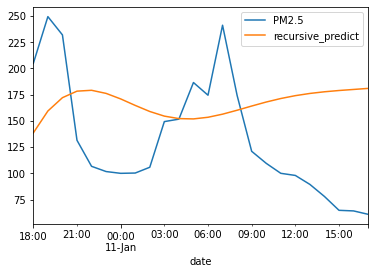

In [28]:
test.plot()

In [29]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

72.04750339555416


In [30]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,204.77,138.497372
2020-01-10 19:00:00,249.29,159.357772
2020-01-10 20:00:00,231.89,172.056815
2020-01-10 21:00:00,131.43,178.276021
2020-01-10 22:00:00,106.64,179.099248
2020-01-10 23:00:00,101.65,176.132877
2020-01-11 00:00:00,99.95,170.874310
2020-01-11 01:00:00,100.23,164.686554
2020-01-11 02:00:00,105.74,158.890154


# Direct Startegy

In [31]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [32]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [33]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.11286788], dtype=float32),
 array([0.14272141], dtype=float32),
 array([0.14220916], dtype=float32),
 array([0.14809327], dtype=float32),
 array([0.16921516], dtype=float32),
 array([0.20805717], dtype=float32),
 array([0.17313673], dtype=float32),
 array([0.1539914], dtype=float32),
 array([0.18308167], dtype=float32),
 array([0.15546317], dtype=float32),
 array([0.1732721], dtype=float32),
 array([0.17034449], dtype=float32),
 array([0.16661142], dtype=float32),
 array([0.19131051], dtype=float32),
 array([0.13500184], dtype=float32),
 array([0.14565286], dtype=float32),
 array([0.14897473], dtype=float32),
 array([0.16521546], dtype=float32),
 array([0.12686408], dtype=float32),
 array([0.13537015], dtype=float32),
 array([0.12565334], dtype=float32),
 array([0.12988304], dtype=float32),
 array([0.126276], dtype=float32),
 array([0.14438073], dtype=float32)]

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

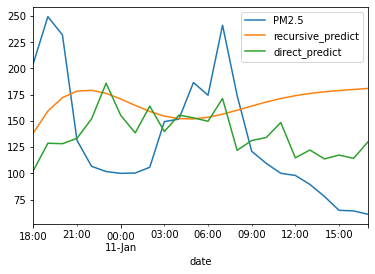

In [35]:
test.plot()

In [36]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

57.04072569584779


In [37]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,204.77,138.497372,102.468694
2020-01-10 19:00:00,249.29,159.357772,128.635320
2020-01-10 20:00:00,231.89,172.056815,128.186326
2020-01-10 21:00:00,131.43,178.276021,133.343750
2020-01-10 22:00:00,106.64,179.099248,151.857086
2020-01-10 23:00:00,101.65,176.132877,185.902105
2020-01-11 00:00:00,99.95,170.874310,155.294340
2020-01-11 01:00:00,100.23,164.686554,138.513463
2020-01-11 02:00:00,105.74,158.890154,164.011085


# Direct Recursive Startegy

In [38]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [39]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [40]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.10942153], dtype=float32),
 array([0.12865989], dtype=float32),
 array([0.14693537], dtype=float32),
 array([0.16676255], dtype=float32),
 array([0.16712418], dtype=float32),
 array([0.16473453], dtype=float32),
 array([0.18092895], dtype=float32),
 array([0.18361536], dtype=float32),
 array([0.19024502], dtype=float32),
 array([0.17326057], dtype=float32),
 array([0.16187865], dtype=float32),
 array([0.18665506], dtype=float32),
 array([0.18781607], dtype=float32),
 array([0.20146567], dtype=float32),
 array([0.17907248], dtype=float32),
 array([0.17037694], dtype=float32),
 array([0.15754381], dtype=float32),
 array([0.18082666], dtype=float32),
 array([0.17940801], dtype=float32),
 array([0.18442118], dtype=float32),
 array([0.15357615], dtype=float32),
 array([0.17571566], dtype=float32),
 array([0.16702528], dtype=float32),
 array([0.1568292], dtype=float32)]

In [41]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

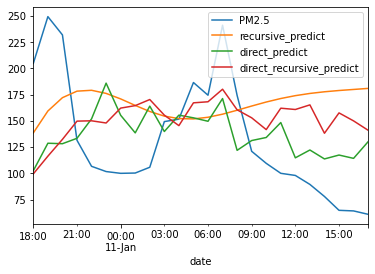

In [42]:
test.plot()

In [43]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

64.94768409397079


In [44]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,204.77,138.497372,102.468694,99.447970
2020-01-10 19:00:00,249.29,159.357772,128.635320,116.310393
2020-01-10 20:00:00,231.89,172.056815,128.186326,132.328855
2020-01-10 21:00:00,131.43,178.276021,133.343750,149.707371
2020-01-10 22:00:00,106.64,179.099248,151.857086,150.024346
2020-01-10 23:00:00,101.65,176.132877,185.902105,147.929813
2020-01-11 00:00:00,99.95,170.874310,155.294340,162.124221
2020-01-11 01:00:00,100.23,164.686554,138.513463,164.478860
2020-01-11 02:00:00,105.74,158.890154,164.011085,170.289758


# MIMO

In [45]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [46]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [47]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [48]:
model.fit(X, y, epochs=3, verbose=0)

In [49]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [50]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [51]:
res.shape

(24, 1)

In [52]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [53]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,204.77,138.497372,102.468694,99.447970,122.061226
2020-01-10 19:00:00,249.29,159.357772,128.635320,116.310393,138.497055
2020-01-10 20:00:00,231.89,172.056815,128.186326,132.328855,138.115662
2020-01-10 21:00:00,131.43,178.276021,133.343750,149.707371,148.640854
2020-01-10 22:00:00,106.64,179.099248,151.857086,150.024346,147.734680
2020-01-10 23:00:00,101.65,176.132877,185.902105,147.929813,145.476593
2020-01-11 00:00:00,99.95,170.874310,155.294340,162.124221,145.410431
2020-01-11 01:00:00,100.23,164.686554,138.513463,164.478860,142.472305
2020-01-11 02:00:00,105.74,158.890154,164.011085,170.289758,133.790894


<AxesSubplot:xlabel='date'>

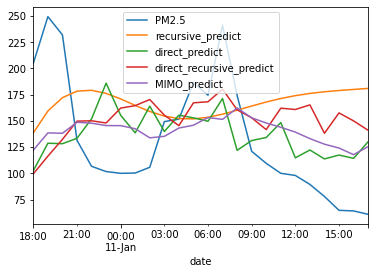

In [54]:
test.plot()

In [55]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

53.26829958512823


# Direct MIMO

In [56]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [57]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [58]:
n_input = 12
n_features = 1
test_predictions = []

q = int(len(scaled_test)/4)

n_output = q

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.12932847, 0.14040755, 0.15406427, 0.15721732, 0.16096638,
         0.1691166 ]], dtype=float32),
 array([[0.14570582, 0.14563002, 0.15671703, 0.15856622, 0.15915018,
         0.15413041]], dtype=float32),
 array([[0.19427615, 0.19510314, 0.19525029, 0.19146794, 0.1868712 ,
         0.17057921]], dtype=float32),
 array([[0.14589836, 0.13686758, 0.12785704, 0.12300353, 0.12025112,
         0.1308246 ]], dtype=float32),
 array([[0.1623332 , 0.16622156, 0.17255853, 0.18245636, 0.1759014 ,
         0.17884171]], dtype=float32),
 array([[0.14521356, 0.14951494, 0.14933665, 0.14626983, 0.14697258,
         0.14464353]], dtype=float32)]

In [59]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [60]:
res = np.array(res[:len(scaled_test)])
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [61]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [62]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,204.77,138.497372,102.468694,99.447970,122.061226,116.896416
2020-01-10 19:00:00,249.29,159.357772,128.635320,116.310393,138.497055,126.607224
2020-01-10 20:00:00,231.89,172.056815,128.186326,132.328855,138.115662,138.577332
2020-01-10 21:00:00,131.43,178.276021,133.343750,149.707371,148.640854,141.340988
2020-01-10 22:00:00,106.64,179.099248,151.857086,150.024346,147.734680,144.627045
2020-01-10 23:00:00,101.65,176.132877,185.902105,147.929813,145.476593,151.770706
2020-01-11 00:00:00,99.95,170.874310,155.294340,162.124221,145.410431,131.251160
2020-01-11 01:00:00,100.23,164.686554,138.513463,164.478860,142.472305,131.184708
2020-01-11 02:00:00,105.74,158.890154,164.011085,170.289758,133.790894,140.902481


<AxesSubplot:xlabel='date'>

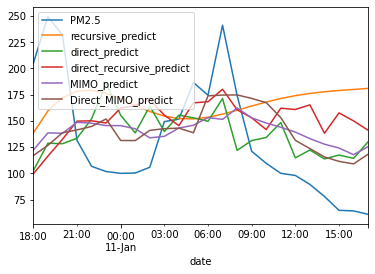

In [63]:
test.plot()

In [64]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

52.214088497245115


In [65]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [66]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [67]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,66.272628,102.301306,105.322030,82.708774,87.873584
2020-01-10 19:00:00,89.932228,120.654680,132.979607,110.792945,122.682776
2020-01-10 20:00:00,59.833185,103.703674,99.561145,93.774338,93.312668
2020-01-10 21:00:00,46.846021,1.913750,18.277371,17.210854,9.910988
2020-01-10 22:00:00,72.459248,45.217086,43.384346,41.094680,37.987045
2020-01-10 23:00:00,74.482877,84.252105,46.279813,43.826593,50.120706
2020-01-11 00:00:00,70.924310,55.344340,62.174221,45.460431,31.301160
2020-01-11 01:00:00,64.456554,38.283463,64.248860,42.242305,30.954708
2020-01-11 02:00:00,53.150154,58.271085,64.549758,28.050894,35.162481


<AxesSubplot:xlabel='date'>

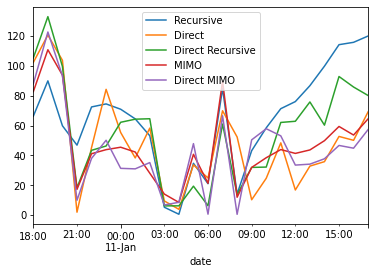

In [68]:
errors.plot()

In [69]:
len(scaled_test)

24